In [2]:
from scipy.stats import norm
import kagglehub
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [3]:
# Enable copy-on-write mode for pandas DataFrames
pd.set_option("mode.copy_on_write", True)


# Downloads and loads the dataset from Kaggle and returns the CSV path
def download_data():
    path = kagglehub.dataset_download("uciml/default-of-credit-card-clients-dataset")
    files = os.listdir(path)
    csv_file = files[0]
    return os.path.join(path, csv_file)


# Reads in the dataset
def load_data(csv_path: str) -> pd.DataFrame:
    return pd.read_csv(csv_path, encoding="ISO-8859-1")

In [4]:
data_ = load_data(download_data())
print(data_.shape)
data_.head()

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [5]:
df = data_[["default.payment.next.month", "LIMIT_BAL", "ID"]].copy()
df.rename(
    columns={
        "LIMIT_BAL": "CREDIT_LINE",
        "default.payment.next.month": "DEFAULT_STATUS",
    },
    inplace=True,
)
print(df.shape)
df.head()

(30000, 3)


,DEFAULT_STATUS,CREDIT_LINE,ID
0,1,20000.0,1
1,1,120000.0,2
2,0,90000.0,3
3,0,50000.0,4
4,0,50000.0,5


In [6]:
credit_lines = df.CREDIT_LINE.values
credit_lines

array([ 20000., 120000.,  90000., ...,  30000.,  80000.,  50000.],
      shape=(30000,))

In [12]:
correlations = [0.05, 0.10, 0.15]
default_rates = [0.03, 0.09, 0.15, 0.2215]
n_simulations = 10000
N = len(credit_lines)

results = []

In [13]:
for correlation_factor in correlations:
    for payment_default in default_rates:
        print(f"\n{'='*60}")
        print(
            f"Running simulation: ρ={correlation_factor:.1%}, PD={payment_default:.2%}"
        )
        print(f"{'='*60}")

        # Computing threshold for current PD
        threshold = norm.ppf(payment_default)

        # Arrays for saving the current results
        total_losses = np.zeros(n_simulations)
        n_user_default = np.zeros(n_simulations)

        # Monte Carlo Simulation
        for i in range(n_simulations):
            systematic_factor = np.random.normal(0, 1)
            idiosyncratic_factor = np.random.normal(0, 1, N)

            # Vasicek Formula
            X = (
                np.sqrt(correlation_factor) * systematic_factor
                + np.sqrt(1 - correlation_factor) * idiosyncratic_factor
            )

            flag = (X < threshold).astype(int)
            n_user_default[i] = np.sum(flag)
            total_losses[i] = np.sum(flag * credit_lines)

        # Compute risk metrics
        expected_loss = np.mean(total_losses)
        mean_default_rate = np.mean(n_user_default) / N

        # VaR y CVaR for different confidence levels
        confidence_level = 99
        var_results = {}
        cvar_results = {}

        var = np.percentile(total_losses, confidence_level)
        cvar = np.mean(total_losses[total_losses >= var])
        var_results[confidence_level] = var
        cvar_results[confidence_level] = cvar

        result = {
            "correlation": correlation_factor,
            "pd": payment_default,
            "expected_loss": expected_loss,
            "mean_default_rate": mean_default_rate,
            "var_99": var_results[confidence_level],
            "cvar_99": cvar_results[confidence_level],
            "max_loss": np.max(total_losses),
            "min_loss": np.min(total_losses),
            "total_losses": total_losses.copy(),  # For plotting
        }
        results.append(result)

        print(f"Default Rate: {payment_default:.2%}")
        print(f"Correlation: {correlation_factor:.1%}")
        print(f"Mean default rate: {mean_default_rate:.2%}")
        print(f"Expected Loss: NT${expected_loss:,.2f}")
        print(f"VaR 99%: NT${var_results[confidence_level]:,.2f}")
        print(f"CVaR 99%: NT${cvar_results[confidence_level]:,.2f}")


Running simulation: ρ=5.0%, PD=3.00%
Default Rate: 3.00%
Correlation: 5.0%
Mean default rate: 3.00%
Expected Loss: NT$150,792,141.44
VaR 99%: NT$409,322,900.00
CVaR 99%: NT$476,658,621.60

Running simulation: ρ=5.0%, PD=9.00%
Default Rate: 9.00%
Correlation: 5.0%
Mean default rate: 9.03%
Expected Loss: NT$453,671,828.28
VaR 99%: NT$1,004,671,700.00
CVaR 99%: NT$1,109,603,043.20

Running simulation: ρ=5.0%, PD=15.00%
Default Rate: 15.00%
Correlation: 5.0%
Mean default rate: 14.97%
Expected Loss: NT$751,981,474.83
VaR 99%: NT$1,471,055,660.00
CVaR 99%: NT$1,611,492,848.00

Running simulation: ρ=5.0%, PD=22.15%
Default Rate: 22.15%
Correlation: 5.0%
Mean default rate: 22.14%
Expected Loss: NT$1,112,391,086.85
VaR 99%: NT$2,009,876,380.00
CVaR 99%: NT$2,170,758,618.40

Running simulation: ρ=10.0%, PD=3.00%
Default Rate: 3.00%
Correlation: 10.0%
Mean default rate: 3.02%
Expected Loss: NT$151,848,705.72
VaR 99%: NT$578,882,400.00
CVaR 99%: NT$700,350,818.40

Running simulation: ρ=10.0%, PD=

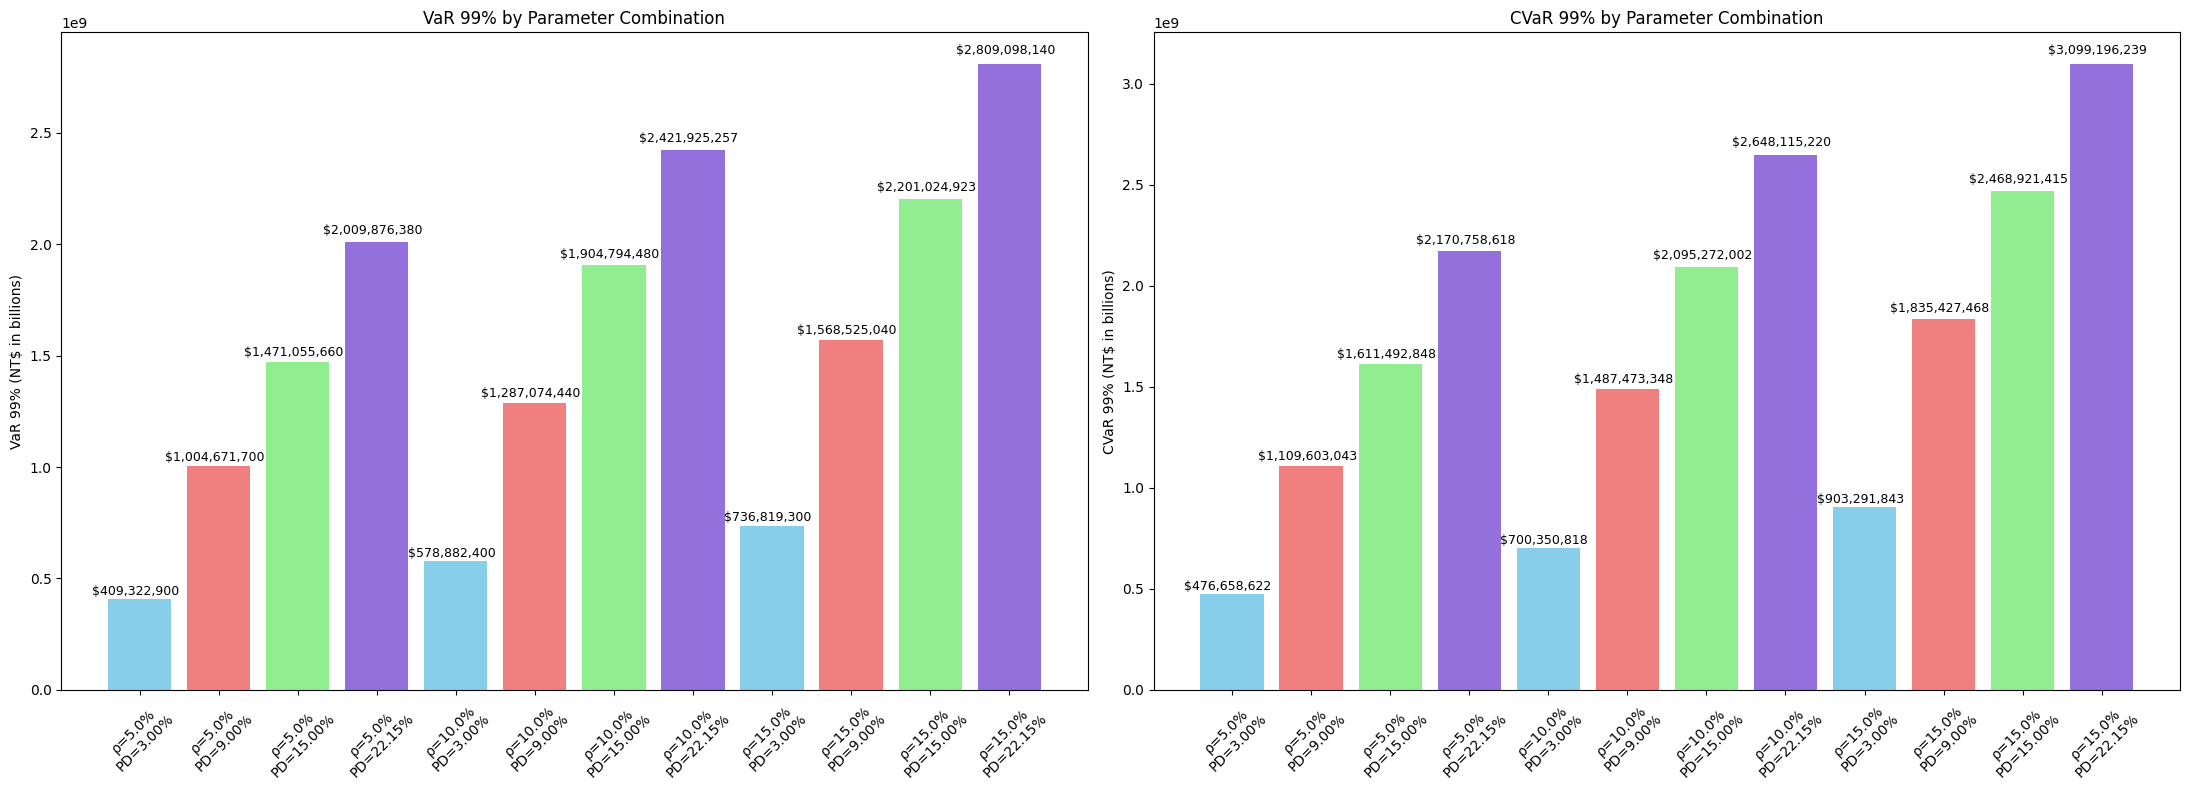

In [27]:
# VaR and CVaR by combination
plt.figure(figsize=(22, 8))

# Subplot 1: VaR by parameter combination
plt.subplot(1, 2, 1)
combinations = [f"ρ={r['correlation']:.1%}\nPD={r['pd']:.2%}" for r in results]
var_values = [r[f"var_{confidence_level}"] for r in results]

bars = plt.bar(
    combinations, var_values, color=["skyblue", "lightcoral", "lightgreen", "mediumpurple"]
)
plt.ylabel(f"VaR {confidence_level}% (NT$ in billions)")
plt.title(f"VaR {confidence_level}% by Parameter Combination")
plt.xticks(rotation=45)
for bar, value in zip(bars, var_values):
    plt.text(
        bar.get_x() + bar.get_width() / 2 - 0.05,
        bar.get_height() + bar.get_height() * 0.01,
        f"${value:,.0f}",
        ha="center",
        va="bottom",
        fontsize=9,
        
    )

# Subplot 2: CVaR by parameter combination
plt.subplot(1, 2, 2)
cvar_values = [r[f"cvar_{confidence_level}"] for r in results]

bars = plt.bar(
    combinations, cvar_values, color=["skyblue", "lightcoral", "lightgreen", "mediumpurple"]
)
plt.ylabel(f"CVaR {confidence_level}% (NT$ in billions)")
plt.title(f"CVaR {confidence_level}% by Parameter Combination")
plt.xticks(rotation=45)
for bar, value in zip(bars, cvar_values):
    plt.text(
        bar.get_x() + bar.get_width() / 2 -0.05,
        bar.get_height() + bar.get_height() * 0.01,
        f"${value:,.0f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.tight_layout()
plt.show()

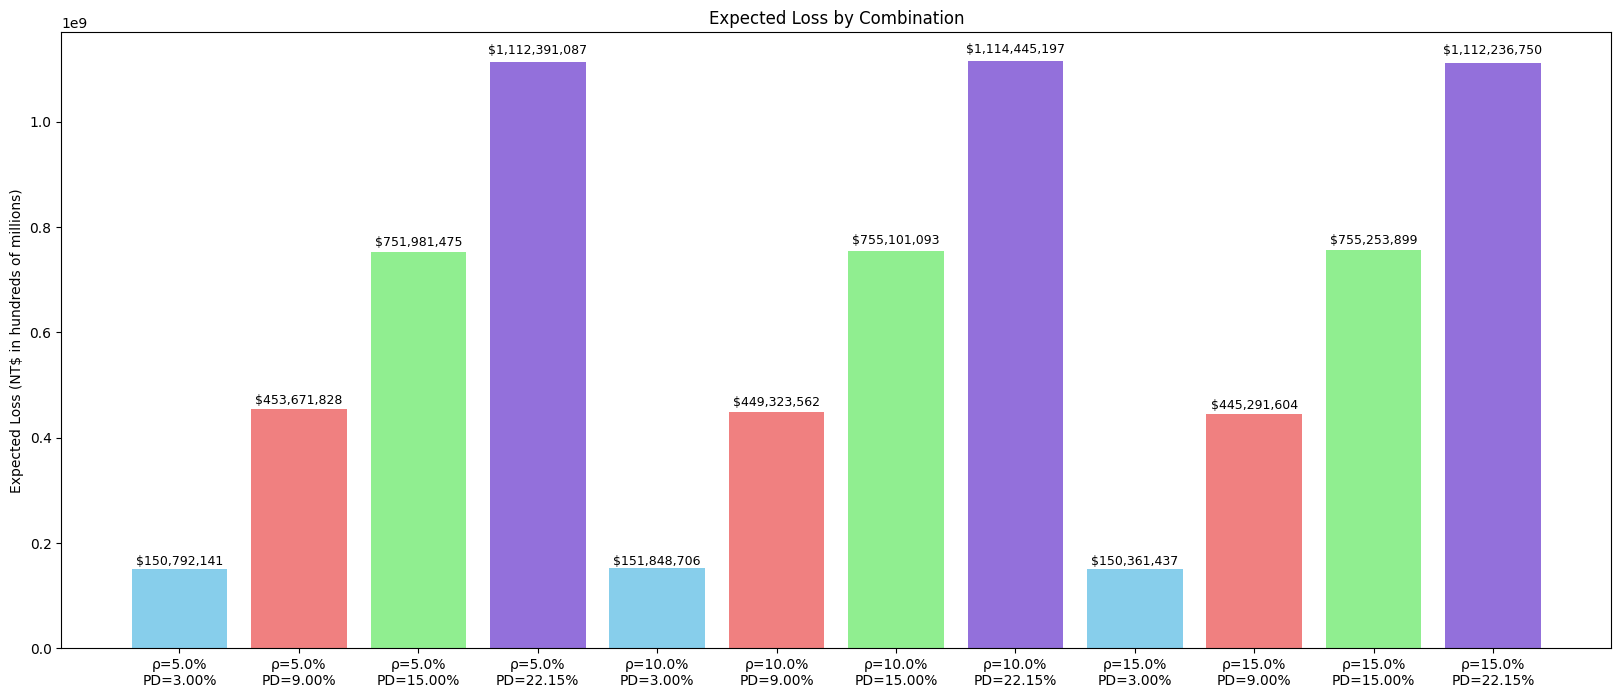

In [36]:
# Expected Loss by combination
plt.figure(figsize=(20, 8))

combinations = [f"ρ={r['correlation']:.1%}\nPD={r['pd']:.2%}" for r in results]
expected_loss_values = [r["expected_loss"] for r in results]

bars = plt.bar(
    combinations,
    expected_loss_values,
    color=["skyblue", "lightcoral", "lightgreen", "mediumpurple"],
)

plt.ylabel("Expected Loss (NT$ in hundreds of millions)")
plt.title("Expected Loss by Combination")
plt.xticks(rotation=0)

# value labels
for bar, value in zip(bars, expected_loss_values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + bar.get_height() * 0.01,
        f"${value:,.0f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.show()


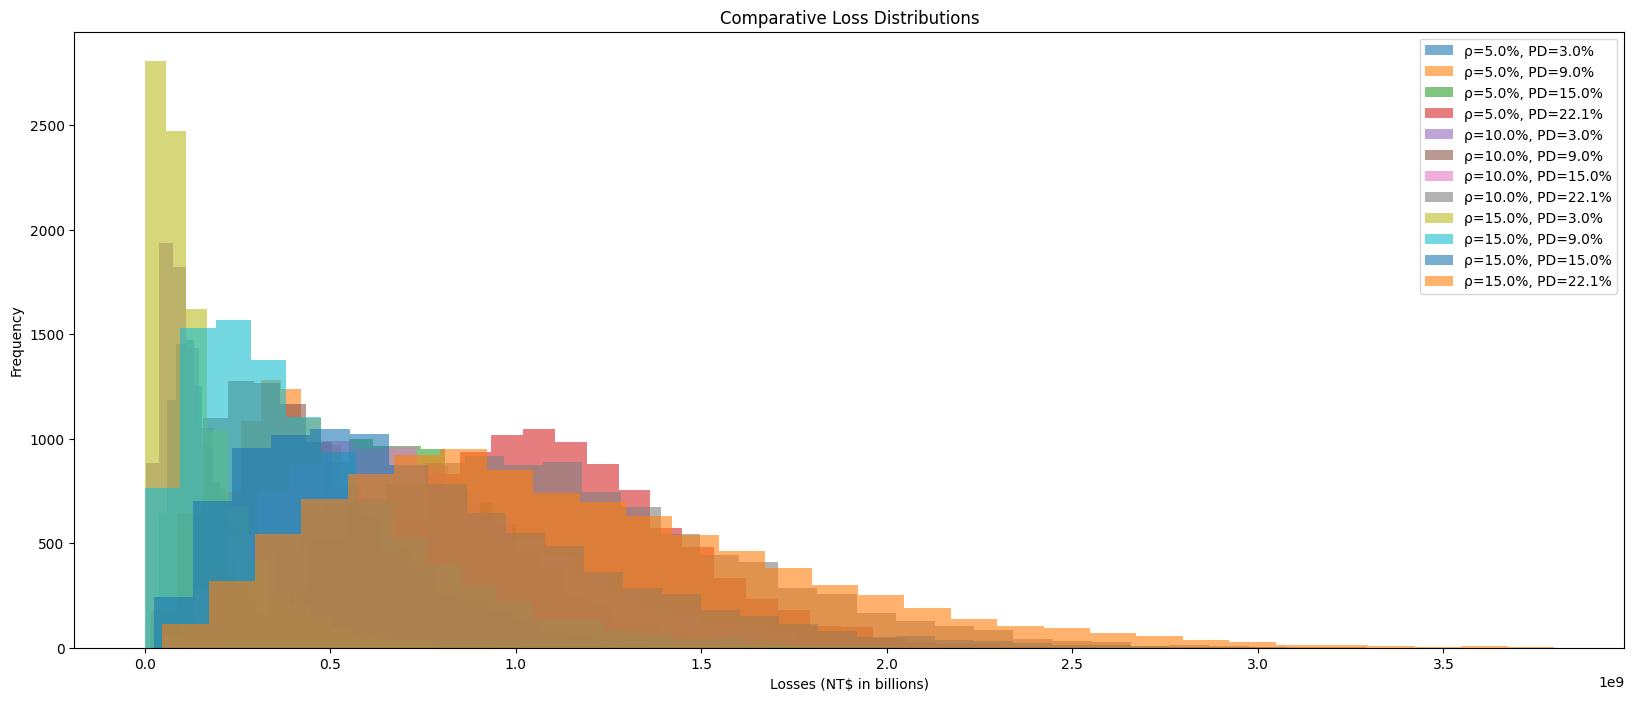

In [35]:
# Loss Distributions
plt.figure(figsize=(20, 8))

for i, result in enumerate(results):
    plt.hist(
        result["total_losses"],
        bins=30,
        alpha=0.6,
        label=f"ρ={result['correlation']:.1%}, PD={result['pd']:.1%}",
    )

plt.xlabel("Losses (NT$ in billions)")
plt.ylabel("Frequency")
plt.title("Comparative Loss Distributions")
plt.legend()

plt.show()


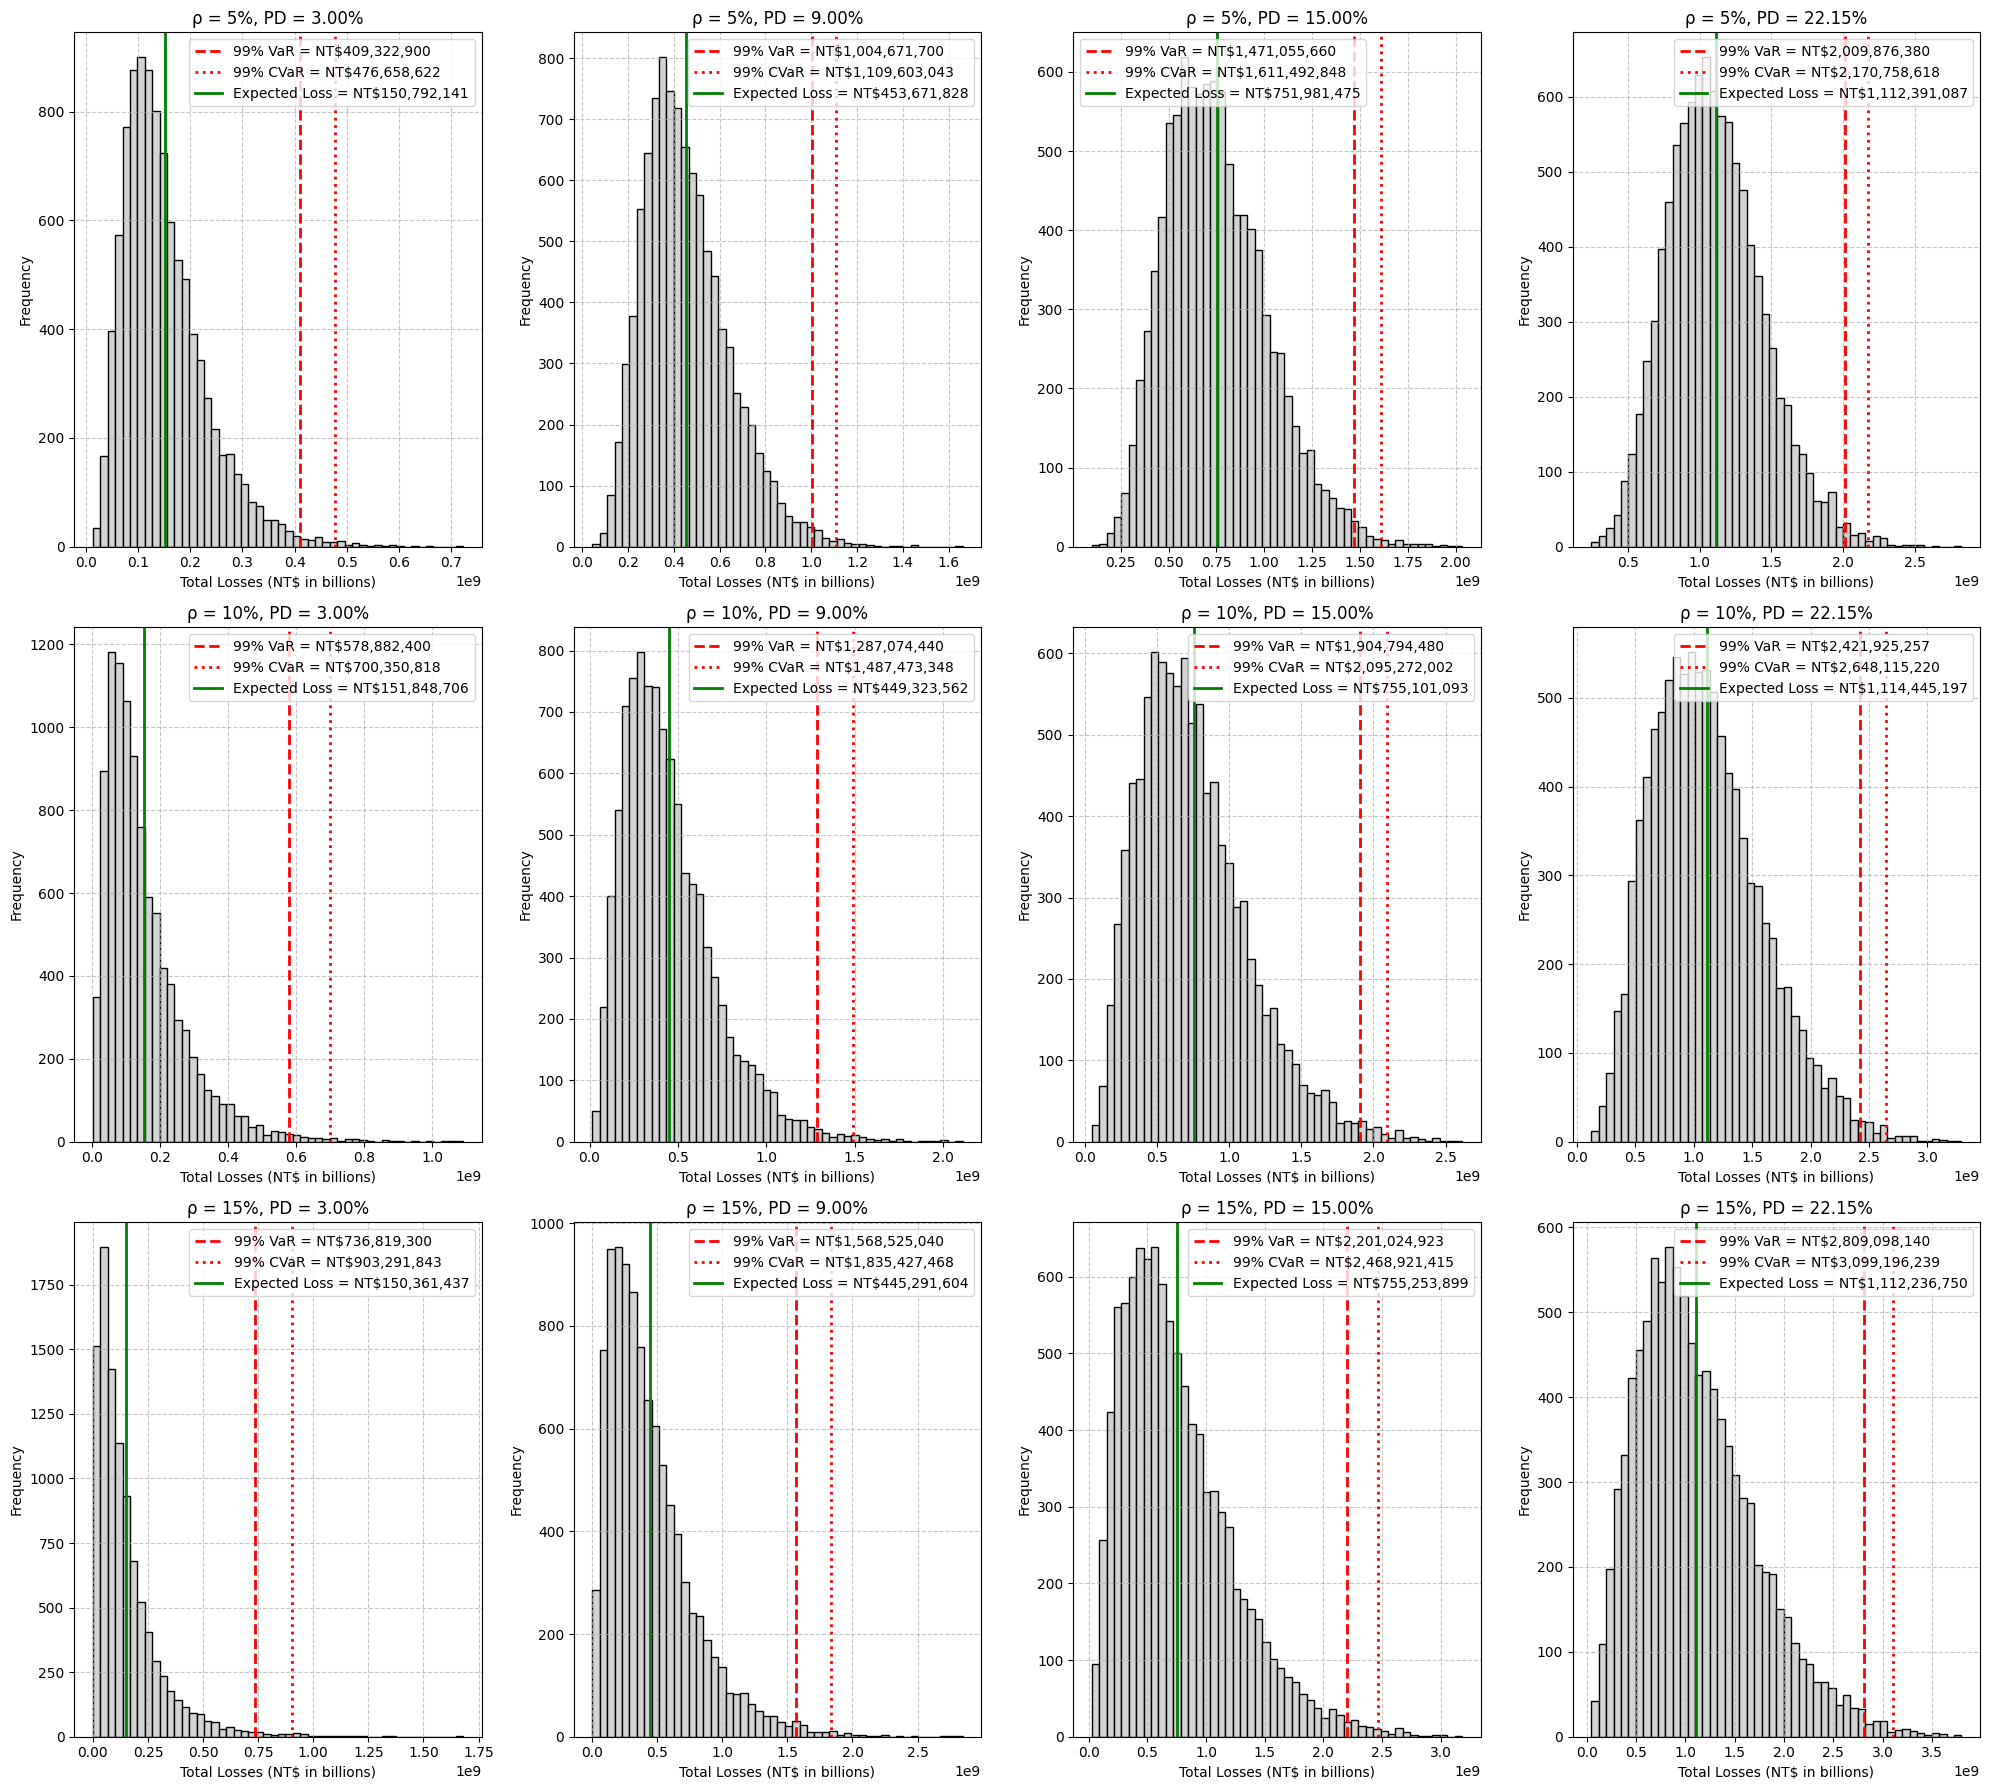

In [40]:
from matplotlib.ticker import ScalarFormatter

# Unique correlation and PD values
correlation_values = sorted(set(r["correlation"] for r in results))
pd_values = sorted(set(r["pd"] for r in results))

# Create figure with one row per correlation
fig, axes = plt.subplots(
    nrows=len(correlation_values),
    ncols=len(pd_values),
    figsize=(20, 6 * len(correlation_values)),
    squeeze=False
)

for row_idx, corr in enumerate(correlation_values):

    subset = [r for r in results if r["correlation"] == corr]
    subset = sorted(subset, key=lambda x: x["pd"])

    for col_idx, r in enumerate(subset):

        ax = axes[row_idx][col_idx]

        losses = r["total_losses"]
        EL = r["expected_loss"]
        VaR99 = r["var_99"]
        CVaR99 = r["cvar_99"]
        PD = r["pd"]

        # Histogram
        ax.hist(losses, bins=50, color='lightgray', edgecolor='black')
        ax.set_title(f"ρ = {corr:.0%}, PD = {PD:.2%}")
        ax.set_xlabel("Total Losses (NT$ in billions)")
        ax.set_ylabel("Frequency")

        # --- Scientific notation for x-axis (e^9) ---
        ax.ticklabel_format(style='sci', axis='x', scilimits=(9, 9))

        # VaR + CVaR lines
        ax.axvline(VaR99, color='red', linestyle='--', linewidth=2,
                   label=f'99% VaR = NT${VaR99:,.0f}')
        ax.axvline(CVaR99, color='red', linestyle=':', linewidth=2,
                   label=f'99% CVaR = NT${CVaR99:,.0f}')

        ax.axvline(EL, color='green', linestyle='-', linewidth=2,
                   label=f'Expected Loss = NT${EL:,.0f}')

        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend()

plt.tight_layout()
plt.show()


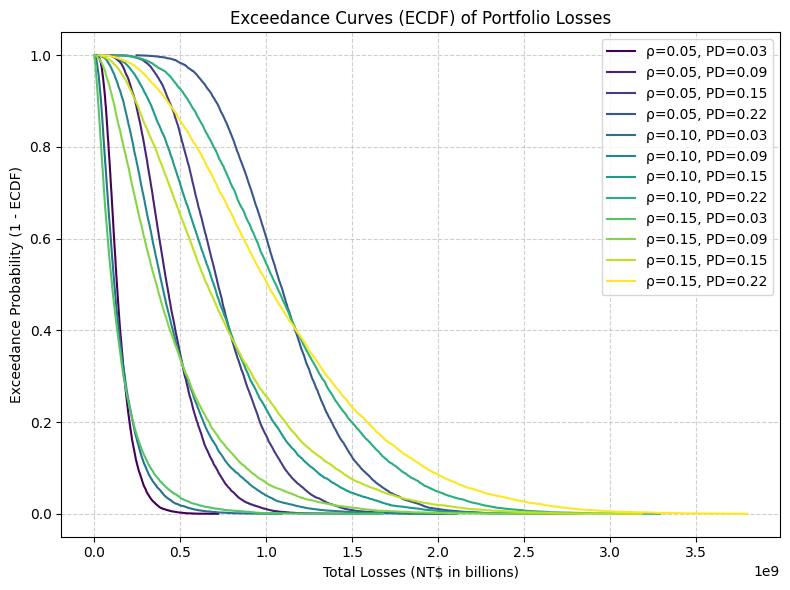

In [42]:

plt.figure(figsize=(8, 6))

# Color map for each scenario
colors = plt.cm.viridis(np.linspace(0, 1, len(results)))

for idx, res in enumerate(results):
    losses = np.sort(res["total_losses"])
    exceedance = 1.0 - np.arange(1, len(losses) + 1) / len(losses)
    
    label = f"ρ={res['correlation']:.2f}, PD={res['pd']:.2f}"
    
    plt.plot(losses, exceedance, label=label, color=colors[idx])

plt.xlabel("Total Losses (NT$ in billions)")
plt.ylabel("Exceedance Probability (1 - ECDF)")
plt.title("Exceedance Curves (ECDF) of Portfolio Losses")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


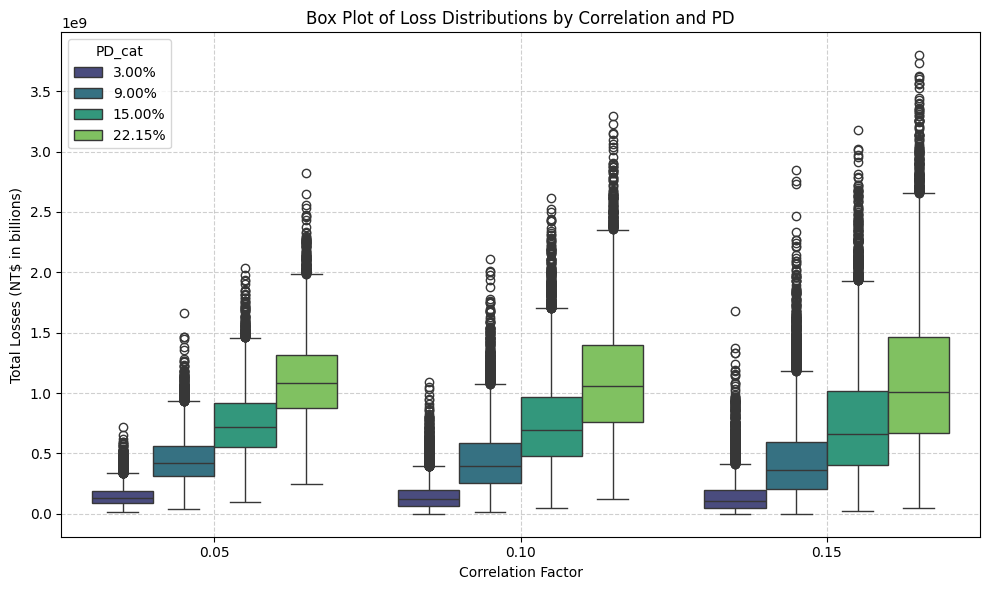

In [45]:
# Create categorical PD labels (2 decimal places)
pd_levels = sorted(df_losses["PD"].unique())
pd_labels = [f"{p*100:.2f}%" for p in pd_levels]   # ← changed here
pd_map = dict(zip(pd_levels, pd_labels))
df_losses["PD_cat"] = df_losses["PD"].map(pd_map)

# Create categorical correlation labels
corr_levels = sorted(df_losses["correlation"].unique())
corr_labels = [f"{c:.2f}" for c in corr_levels]
corr_map = dict(zip(corr_levels, corr_labels))
df_losses["corr_cat"] = df_losses["correlation"].map(corr_map)

# Cast both to ordered categorical
df_losses["PD_cat"] = pd.Categorical(df_losses["PD_cat"], categories=pd_labels, ordered=True)
df_losses["corr_cat"] = pd.Categorical(df_losses["corr_cat"], categories=corr_labels, ordered=True)

# ---- BOX PLOT ONLY ----
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="corr_cat",
    y="loss",
    hue="PD_cat",
    data=df_losses,
    palette="viridis"
)

plt.title("Box Plot of Loss Distributions by Correlation and PD")
plt.ylabel("Total Losses (NT$ in billions)")
plt.xlabel("Correlation Factor")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [47]:
print(f"\n{'='*100}")
print("COMPREHENSIVE RESULTS SUMMARY")
print(f"{'='*100}")

summary_data = []
for result in results:
    summary_data.append(
        {
            "Correlation": f"{result['correlation']:.1%}",
            "PD": f"{result['pd']:.2%}",
            "Mean Default Rate": f"{result['mean_default_rate']:.2%}",
            "Expected Loss (NT$)": f"{result['expected_loss']:,.0f}",
            "VaR 99% (NT$)": f"{result['var_99']:,.0f}",
            "CVaR 99% (NT$)": f"{result['cvar_99']:,.0f}",
            "Max Loss (NT$)": f"{result['max_loss']:,.0f}",
        }
    )

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))


COMPREHENSIVE RESULTS SUMMARY
Correlation     PD Mean Default Rate Expected Loss (NT$) VaR 99% (NT$) CVaR 99% (NT$) Max Loss (NT$)
       5.0%  3.00%             3.00%         150,792,141   409,322,900    476,658,622    722,600,000
       5.0%  9.00%             9.03%         453,671,828 1,004,671,700  1,109,603,043  1,661,060,000
       5.0% 15.00%            14.97%         751,981,475 1,471,055,660  1,611,492,848  2,033,330,000
       5.0% 22.15%            22.14%       1,112,391,087 2,009,876,380  2,170,758,618  2,820,682,000
      10.0%  3.00%             3.02%         151,848,706   578,882,400    700,350,818  1,091,046,000
      10.0%  9.00%             8.94%         449,323,562 1,287,074,440  1,487,473,348  2,108,673,680
      10.0% 15.00%            15.03%         755,101,093 1,904,794,480  2,095,272,002  2,613,393,680
      10.0% 22.15%            22.18%       1,114,445,197 2,421,925,257  2,648,115,220  3,291,879,680
      15.0%  3.00%             2.99%         150,361,437   7